In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/BHBikash/FinalDataset/main/Dataset%20O2N.csv')

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(ascending=True, inplace=True)

In [ ]:
scaler = MinMaxScaler (feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

In [ ]:
train_size = int(len(scaled_data) * 0.99)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [ ]:
def create_sequences (data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [ ]:
sequence_length = 10
X_train, y_train = create_sequences (train_data, sequence_length)
X_test, y_test = create_sequences (test_data, sequence_length)

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout (0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout (0.2))
model.add(LSTM(units=50))
model.add(Dropout (0.2))
model.add(Dense (units=1))

In [ ]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32)

In [ ]:
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [ ]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

In [ ]:
pred_df = pd.DataFrame({'Date': data.index[train_size+sequence_length:], 'Forecasted Price': y_pred.flatten()})

In [ ]:
print("Predicted Values:")
print (pred_df)
print("\nMean Squared Error:", mse)
print("RMSE:", rmse)
print("Mean Absolute Error:", mae)

Predicted Values:
         Date  Forecasted Price
0  2023-05-25        106.668289
1  2023-05-26        106.657318
2  2023-05-29        106.639313
3  2023-05-30        106.611038
4  2023-05-31        106.595612
5  2023-06-01        106.582191
6  2023-06-02        106.573067
7  2023-06-05        106.568222
8  2023-06-06        106.585976
9  2023-06-07        106.620499
10 2023-06-08        106.685600
11 2023-06-09        106.767517
12 2023-06-12        106.855423
13 2023-06-13        106.943642
14 2023-06-14        107.022644
15 2023-06-15        107.127327

Mean Squared Error: 1.3338370897166907
RMSE: 1.1549186506921996
Mean Absolute Error: 1.0543326644897473


In [ ]:
merged_df = pd.merge(data, pred_df, on='Date', how='inner')
merged_df['Difference'] = merged_df['Price'] - merged_df['Forecasted Price']
print(merged_df[[ 'Date', 'Price', 'Forecasted Price', 'Difference']])

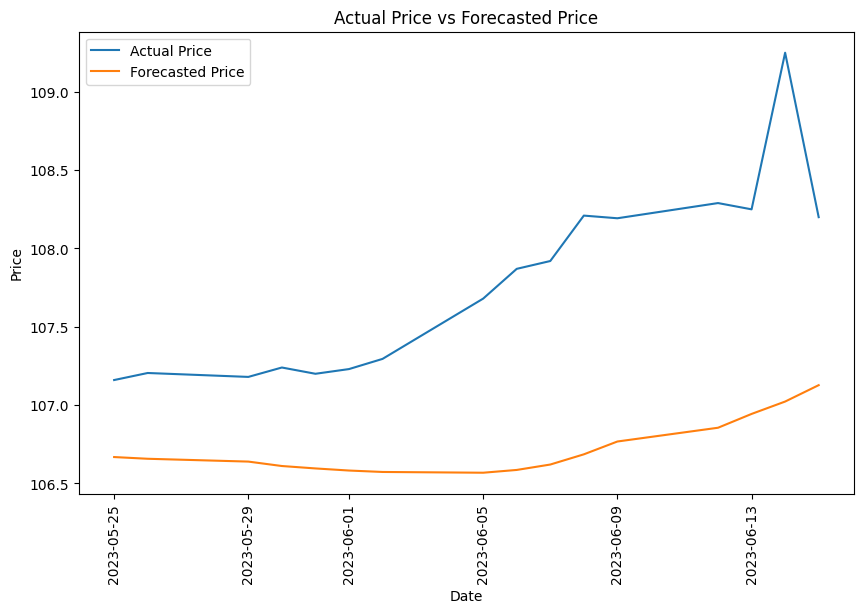

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], merged_df['Price'], label='Actual Price')
plt.plot(merged_df['Date'], merged_df['Forecasted Price'], label='Forecasted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Price vs Forecasted Price')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [ ]:
last_sequence = scaled_data[-sequence_length:]

In [ ]:
future_predictions = []

In [ ]:
for _ in range(180):
    next_prediction = model.predict(last_sequence.reshape(1, sequence_length, 1))
    future_predictions.append(next_prediction[0][0])
    last_sequence = np.append(last_sequence[1:], next_prediction[0])

In [ ]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [ ]:
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=180, freq='D')

In [ ]:
future_df = pd.DataFrame({'Date': future_dates, 'Forecasted Price': future_predictions.flatten()})

In [ ]:
future_df['Date'] = pd.to_datetime(future_df['Date'])
print("Future Predictions:")
print(future_df)

Future Predictions:
          Date  Forecasted Price
0   2023-06-16        107.215233
1   2023-06-17        107.231552
2   2023-06-18        107.177681
3   2023-06-19        107.083176
4   2023-06-20        106.969986
..         ...               ...
175 2023-12-08        104.909973
176 2023-12-09        104.909966
177 2023-12-10        104.909958
178 2023-12-11        104.909950
179 2023-12-12        104.909950

[180 rows x 2 columns]


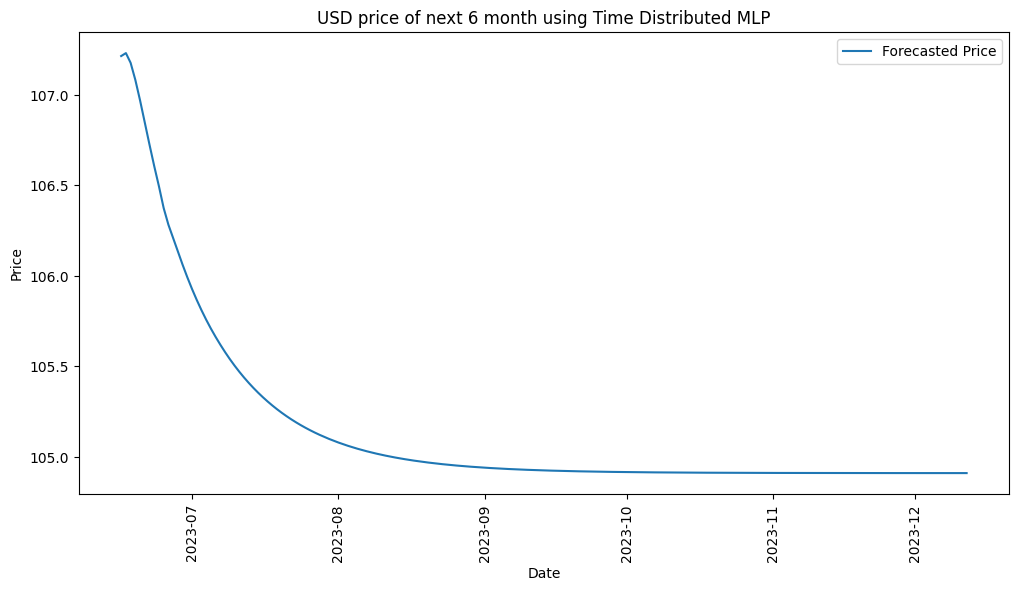

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(future_prediction['Date'], future_prediction['Forecasted Price'], label='Forecasted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('USD price of next 6 month using Gans')
plt.legend()
plt.xticks(rotation=90)
plt.show()